1 frame test

Put better figures

Use only touch data to predict image

Write on paper the difference between feeding between 25, 10 and 1 frame

Record a live test

Avoid Pain -DONE

UDPcmd PORT 50000 -DONE

Defaul right arm: 76.76 87.65 4.59 3.94 78.48 -4.69 -50.63

Default Head: -3.10 31.37

To avoid pain move 4th joint - DONE


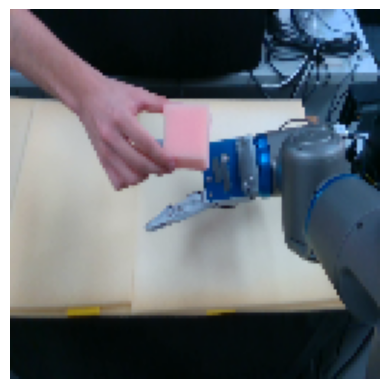

1/1 [==============================] - 0s 34ms/step
0.29635635
Results saved in Results_NoTouch/test_25


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))
import tensorflow_probability as tfp
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import imageio
from tqdm import tqdm
import psutil
import pickle

import PIL.Image as Image

from tensorflow.keras import backend as k

import socket
from time import sleep
import threading

targetIP = "192.168.5.100"
targetPORT = 50000

server = (targetIP,targetPORT);
udpClient = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

default_right = "setq_deg rarm 76.76 87.65 4.59 3.94 78.48 -4.69 -50.63"
avoid_right = "setq_deg rarm 76.76 87.65 4.59 -11.94 78.48 -4.69 -50.63"
head_default = "setq_deg head -3.10 31.37"


# Load the model
@tf.keras.utils.register_keras_serializable()
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, _ = tf.split(y_true, 2, axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

#model = keras.models.load_model("models/model488.keras", custom_objects={"custom_loss": custom_loss})
model = keras.models.load_model("model250.keras", custom_objects={"custom_loss": custom_loss})

#model.summary()

fps = 30  # Frame rate
frames = []
size = 55
predict = 2

def observation(n_inp, frames, size):
    """Prepare input data for the model."""

    img_coef = np.ones((1, 128)) * 1  # Coefficients for image weighting
    touch_coef = np.ones((1, 128)) * 0  # Coefficients for touch weighting

    observation = np.zeros((1, n_inp, 128, 128, 4)) 
    observation_touch = np.zeros((1, n_inp, 9)) 
    target_X = np.zeros((1, 1))
    time_len = size
    times = np.linspace(0, 1, time_len)

    for idx in range(n_inp):
        observation[0, idx, :, :, 0] = np.ones((128, 128)) * times[idx]
        
        image = frames[idx]
        image_resized = cv2.resize(image, (128, 128))
        #image_resized = tf.image.resize(image, (128,128))
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        
        # Normalize the image correctly to range [0, 1]
        observation[0, idx, :, :, 1:] = image_rgb.astype(np.float32) / 255.0

        display.clear_output(wait=True)
        plt.imshow(observation[0, idx, :, :, 1:])
        plt.axis('off')  # Turn off axis for a clean display
        plt.show()

        observation_touch[0, idx, 0] = times[idx]

    
    target_X[0, 0] = times[n_inp]

    return [observation, observation_touch, target_X, img_coef, touch_coef], times


def save_results(pred_img_values, pred_touch_values, classification, input_images):
    """Saves prediction results into a new test folder."""
    
    # Create 'results' directory if it does not exist
    results_dir = "Results_NoTouch"
    os.makedirs(results_dir, exist_ok=True)
    
    # Determine next test folder number
    existing_tests = [d for d in os.listdir(results_dir) if d.startswith("test_")]
    test_numbers = [int(d.split("_")[1]) for d in existing_tests if d.split("_")[1].isdigit()]
    next_test_number = max(test_numbers) + 1 if test_numbers else 1
    
    # Create new test folder
    test_folder = os.path.join(results_dir, f"test_{next_test_number}")
    os.makedirs(test_folder, exist_ok=True)

    input_folder = os.path.join(test_folder, "input_images")
    os.makedirs(input_folder, exist_ok=True)
    
        # Save input images (observations)
    for i, img in enumerate(input_images):
        img = (img).astype(np.uint8)  # Convert normalized image to 8-bit
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        
        img_path = os.path.join(input_folder, f"input_{i}.jpeg")
        cv2.imwrite(img_path, img)



    # Save predicted images
    for i, img in enumerate(pred_img_values):
        img = (img[:, :, :3] * 255).astype(np.uint8)  # Convert to 8-bit format
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img_path = os.path.join(test_folder, f"predicted_{i}.jpeg")
        cv2.imwrite(img_path, img)
    
    # # Save touch predictions
    # touch_file = os.path.join(test_folder, "touch_predictions.npy")
    # np.save(touch_file, pred_touch_values)

    # Save touch predictions as .txt file (human-readable)
    touch_txt_file = os.path.join(test_folder, "touch_predictions.txt")
    with open(touch_txt_file, "w") as f:
        for i, touch_values in enumerate(pred_touch_values):
            f.write(f"Step {i}: {touch_values.tolist()}\n")
    
    # Save touch classification
    classification_file = os.path.join(test_folder, "touch_type.txt")
    with open(classification_file, "w") as f:
        f.write(classification)
    
    print(f"Results saved in {test_folder}")


def return_to_default():
    encmess = default_right.encode()
    udpClient.sendto(encmess, server) 



def classi(pred_touch_values, pred_img_values, count, frames):
    """Classify touch levels based on predictions."""
    ignore_indices = {0,4}
    mean = []

    for i in range(count):
        arr = pred_touch_values[i]
        mask = np.ones_like(arr, dtype=bool)
        mask[list(ignore_indices)] = False 

        filtered_arr = arr[mask]

        max_value = np.max(filtered_arr)
        mean.append(max_value)
        # pred_mean = np.mean(pred_touch_values)
        # mean.append(pred_mean)

    mean_value = np.mean(mean)
    print(mean_value)

    if mean_value >= 0.69:
        # Publish joints position maybe just add some value to the original position
        classification = "PAIN"
        #message = "getq_deg rarm"
        encmess = avoid_right.encode()
        sentBytesCount = udpClient.sendto(encmess, server)
        threading.Timer(5.0, return_to_default).start()
    else:
        classification = "NO PAIN"
        encmess = default_right.encode()
        sentBytesCount = udpClient.sendto(encmess, server)

    save_results(pred_img_values, pred_touch_values, classification, frames)

while True:
    try:
        if os.path.exists("/tmp/latest_frame.npz"):  # Check if file exists
            data = np.load("/tmp/latest_frame.npz", allow_pickle=True)  # Fix: Enable pickled data
            
            if "frame" in data:
                img = data["frame"]

                # Ensure correct data type and shape
                if isinstance(img, np.ndarray) and img.size > 0:
                    if img.shape == (480, 640, 3):
                        cv2.imshow("Live Video Stream", img)  # Show video
                        frames.append(img)
                        #key = cv2.waitKey(int(1000 / fps))  # Wait based on FPS
                        cv2.waitKey(100)
                        #print(len(frames))
                        
                        # Convert list to array only when needed
                        if len(frames) == 3:  
                            n_inp = len(frames)
                            inp, times = observation(n_inp, frames, size)  # Fix: Convert frames to NumPy array
                            step_predictions = []
                            step_real_values = []
                            count = 0
                            for i in range(n_inp, size-19):
                                if i % 5 == 0:
                                    for j in range(2):
                                        inp_copy = inp.copy() 
                                        inp_copy[2] = np.array([[times[i]]])
                                        pred = model.predict(inp_copy)

                                        step_predictions.append(pred)
                                        i += 1
                                        count +=1
                            pred_img_values = np.array([p[0].squeeze() for p in step_predictions])  
                            pred_touch_values = np.array([p[1].squeeze() for p in step_predictions])
                            #print(pred_touch_values)
                            classi(pred_touch_values, pred_img_values, count, frames)

                            # display.clear_output(wait=True)
                            # display.display(pl.gcf())
                            # plt.imshow(pred_img_values [0,:,:,:3])
                            # plt.show()

                            #frames = []
                            del inp, inp_copy, pred

                        # if key == 27:  # Press 'Esc' to exit
                        #     break
                    else:
                        print("Skipping corrupted frame: Wrong shape", img.shape)
                else:
                    print("Skipping: Invalid image data")

    except Exception as e:
        print("Error loading image:", str(e))

cv2.destroyAllWindows()
